In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tools import *
import seaborn as sns
%load_ext autoreload
%autoreload 2

In [52]:
# --- Load SDG Index data ---
data_path = r"../data/full_data_set.xlsx"
df = pd.read_excel(data_path, sheet_name="Backdated SDG Index")

# Remove aggregates (ids starting with "_")
df = df[~df["id"].astype(str).str.startswith("_")].copy()

# --- Clean numeric columns (sdgi_s + goals) ---
goal_cols = [c for c in df.columns if c.startswith("goal")]
all_cols = ["sdgi_s"] + goal_cols
for col in all_cols:
    df[col] = df[col].astype(str).str.replace(",", ".").astype(float)

# --- Load population data ---
population_path = r"../data/population_data.xlsx"
df_pop = pd.read_excel(population_path, sheet_name="DATA")

# Reshape into long format
df_pop_long = df_pop.melt(
    id_vars=["Country Name", "Country Code"],
    var_name="year",
    value_name="population"
)
df_pop_long["year"] = pd.to_numeric(df_pop_long["year"], errors="coerce")

start_year, end_year = 2000, 2024

# Extract 2024 only
pop_2024 = df_pop_long[df_pop_long["year"] == end_year][["Country Code", "population"]]

# Split into start and end year
df_start = df[df["year"] == start_year].set_index("id")[all_cols+ ["indexreg_"]]
df_end   = df[df["year"] == end_year].set_index("id")[all_cols]

# --- Build structured DataFrame ---
summary = pd.DataFrame(index=df_start.index)

for col in all_cols:
    summary[f"{col}_start"] = df_start[col]
    summary[f"{col}_rel_change"] = (
        (df_end[col] - df_start[col])
    )
    
summary["region"] = df_start["indexreg_"]

# Add population
summary = summary.reset_index().merge(
    pop_2024, left_on="id", right_on="Country Code", how="left"
).drop(columns=["Country Code"])

# Force population to float immediately
summary["population"] = pd.to_numeric(summary["population"], errors="coerce").astype(float)

summary = summary.set_index("id")

# Build stable region → code mapping from the full dataset
region_categories = pd.Categorical(summary["region"].dropna()).categories
region_to_code = {region: i for i, region in enumerate(region_categories)}

In [53]:
summary.region.value_counts()

region
Africa         49
OECD           38
LAC            29
E_Euro_Asia    23
E_S_Asia       21
MENA           17
Oceania        12
W_Europe        4
Name: count, dtype: int64

In [54]:
# which countries are W_Europe
summary[summary.region == "W_Europe"]

,sdgi_s_start,sdgi_s_rel_change,goal1_start,goal1_rel_change,goal2_start,goal2_rel_change,goal3_start,goal3_rel_change,goal4_start,goal4_rel_change,...,goal14_start,goal14_rel_change,goal15_start,goal15_rel_change,goal16_start,goal16_rel_change,goal17_start,goal17_rel_change,region,population
id,,,,,,,,,,,,,,,,,,,,,
AND,69.534100,10.365754,NaN,NaN,91.095800,-2.7182,91.811600,4.185800,52.375667,44.117667,...,NaN,NaN,64.416,7.233667,87.77880,-12.56900,54.79160,3.03920,W_Europe,81938.0
LIE,81.774128,5.076655,NaN,NaN,96.418667,0.0000,NaN,NaN,87.879667,8.407000,...,NaN,NaN,92.267,-0.250000,97.08140,-6.58840,60.14525,2.77775,W_Europe,40197.0
MCO,80.209461,7.820776,NaN,NaN,96.418667,0.0000,92.872500,1.554875,94.631000,0.255333,...,NaN,NaN,NaN,NaN,83.65925,5.86875,50.41180,0.35380,W_Europe,38631.0
SMR,79.128778,6.758495,NaN,NaN,97.314000,0.0000,90.888222,1.882778,93.351000,0.101250,...,NaN,NaN,NaN,NaN,100.00000,0.00000,68.46300,4.42825,W_Europe,33977.0


In [55]:
import pandas as pd
import plotly.express as px

# Load your data (replace 'your_data.csv' with your file)
df = summary

# Ensure the country code is a column, not index
df = df.reset_index().rename(columns={'id': 'country_code'})

# Create the choropleth map
fig = px.choropleth(
    df,
    locations='country_code',  # ISO-3 codes
    color='region',            # Color by region
    hover_name='country_code', # Show country code on hover
    color_discrete_sequence=px.colors.qualitative.Set3 # Distinct colors
)

# Customize layout
fig.update_layout(
    title_text='World Map by Region',
    geo=dict(
        showframe=False,
        showcoastlines=True,
    )
)

fig.show()


In [65]:
import pandas as pd
import plotly.express as px

# Prepare data for 2024 only
df_map = summary.reset_index()[["id", "sdgi_s_start", "sdgi_s_rel_change", "population"]].copy()
df_map["sdgi_s_2024"] = df_map["sdgi_s_start"] + df_map["sdgi_s_rel_change"]

# Create the choropleth map
fig = px.choropleth(
    df_map,
    locations="id",
    color="sdgi_s_2024",
    hover_name="id",
    color_continuous_scale="Plasma",
)

# Clean layout and remove Arctic
fig.update_layout(
    geo=dict(
        showframe=False,
        showcoastlines=True,
        lataxis=dict(range=[-60, 90])  # Restrict latitude to remove Arctic
    ),
    coloraxis_colorbar=dict(title="FN Indeks"),
    title=None
)

# Export to PNG
# fig.write_image("../output/sdgi_2024_map.png", width=1200, height=700)
fig.show()



In [45]:
# regression
import statsmodels.formula.api as smf

In [46]:
# Prepare data
df_reg = summary[['sdgi_s_start', 'sdgi_s_rel_change', 'region', 'population']].dropna()

# Ensure numeric columns
df_reg['sdgi_s_start'] = pd.to_numeric(df_reg['sdgi_s_start'], errors='coerce')
df_reg['sdgi_s_rel_change'] = pd.to_numeric(df_reg['sdgi_s_rel_change'], errors='coerce')
df_reg['population'] = pd.to_numeric(df_reg['population'], errors='coerce')
df_reg = df_reg.dropna(subset=['sdgi_s_start', 'sdgi_s_rel_change', 'population'])

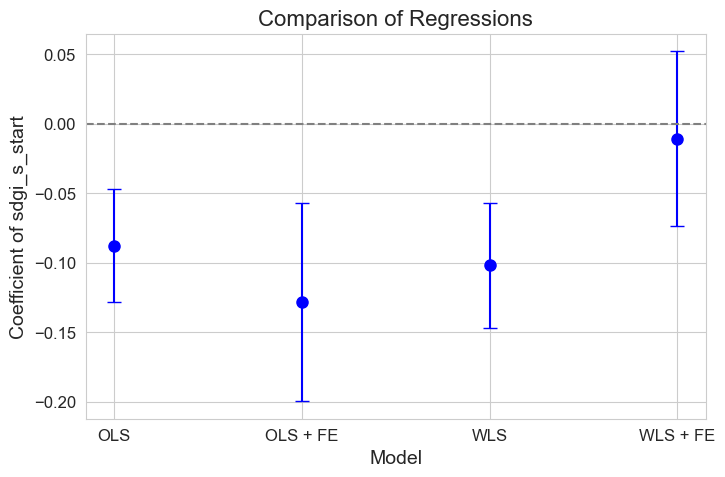

In [47]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Prepare data
df = summary[['sdgi_s_start', 'sdgi_s_rel_change', 'region', 'population']].dropna()
df['sdgi_s_start'] = pd.to_numeric(df['sdgi_s_start'], errors='coerce')
df['sdgi_s_rel_change'] = pd.to_numeric(df['sdgi_s_rel_change'], errors='coerce')
df['population'] = pd.to_numeric(df['population'], errors='coerce')
df = df.dropna(subset=['sdgi_s_start', 'sdgi_s_rel_change', 'population'])

# Within transformation for FE
df['sdgi_s_start_within'] = df['sdgi_s_start'] - df.groupby('region')['sdgi_s_start'].transform('mean')
df['sdgi_s_rel_change_within'] = df['sdgi_s_rel_change'] - df.groupby('region')['sdgi_s_rel_change'].transform('mean')

# Define regressions
regressions = {
    'OLS': sm.OLS(df['sdgi_s_rel_change'], sm.add_constant(df['sdgi_s_start'])).fit(),
    'OLS + FE': sm.OLS(df['sdgi_s_rel_change_within'], sm.add_constant(df['sdgi_s_start_within'])).fit(),
    'WLS': sm.WLS(df['sdgi_s_rel_change'], sm.add_constant(df['sdgi_s_start']), weights=df['population']).fit(),
    'WLS + FE': sm.WLS(df['sdgi_s_rel_change_within'], sm.add_constant(df['sdgi_s_start_within']), weights=df['population']).fit()
}

# Extract coefficients and confidence intervals
coef_df = pd.DataFrame([
    {
        'Model': name,
        'Coef': reg.params['sdgi_s_start'] if 'sdgi_s_start' in reg.params else reg.params['sdgi_s_start_within'],
        'CI_low': reg.conf_int().loc['sdgi_s_start', 0] if 'sdgi_s_start' in reg.params else reg.conf_int().loc['sdgi_s_start_within', 0],
        'CI_high': reg.conf_int().loc['sdgi_s_start', 1] if 'sdgi_s_start' in reg.params else reg.conf_int().loc['sdgi_s_start_within', 1]
    }
    for name, reg in regressions.items()
])

# Vertical plot: models on x-axis, coefficient on y-axis
plt.figure(figsize=(8,5))
plt.errorbar(coef_df['Model'], coef_df['Coef'], 
             yerr=[coef_df['Coef'] - coef_df['CI_low'], coef_df['CI_high'] - coef_df['Coef']],
             fmt='o', color='blue', capsize=5)
plt.axhline(0, color='grey', linestyle='--')  # Horizontal line at 0
plt.ylabel('Coefficient of sdgi_s_start')
plt.xlabel('Model')
plt.title('Comparison of Regressions')
plt.show()


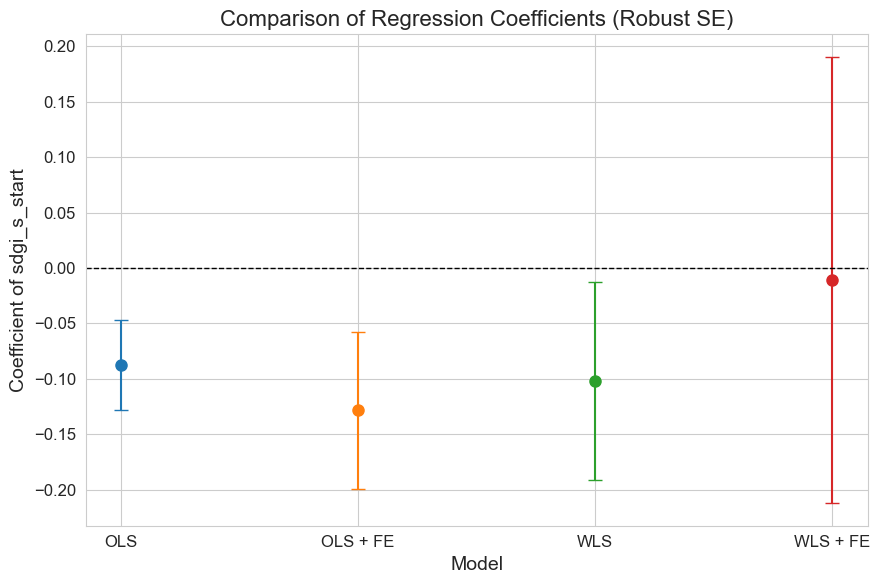

In [48]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare data
df = summary[['sdgi_s_start', 'sdgi_s_rel_change', 'region', 'population']].dropna()
df['sdgi_s_start'] = pd.to_numeric(df['sdgi_s_start'], errors='coerce')
df['sdgi_s_rel_change'] = pd.to_numeric(df['sdgi_s_rel_change'], errors='coerce')
df['population'] = pd.to_numeric(df['population'], errors='coerce')
df = df.dropna(subset=['sdgi_s_start', 'sdgi_s_rel_change', 'population'])

# Within transformation for FE
df['sdgi_s_start_within'] = df['sdgi_s_start'] - df.groupby('region')['sdgi_s_start'].transform('mean')
df['sdgi_s_rel_change_within'] = df['sdgi_s_rel_change'] - df.groupby('region')['sdgi_s_rel_change'].transform('mean')

# Define regressions with robust SE
regressions = {
    'OLS': sm.OLS(df['sdgi_s_rel_change'], sm.add_constant(df['sdgi_s_start'])).fit(cov_type='HC3'),
    'OLS + FE': sm.OLS(df['sdgi_s_rel_change_within'], sm.add_constant(df['sdgi_s_start_within'])).fit(cov_type='HC3'),
    'WLS': sm.WLS(df['sdgi_s_rel_change'], sm.add_constant(df['sdgi_s_start']), weights=df['population']).fit(cov_type='HC3'),
    'WLS + FE': sm.WLS(df['sdgi_s_rel_change_within'], sm.add_constant(df['sdgi_s_start_within']), weights=df['population']).fit(cov_type='HC3')
}

# Extract coefficients and robust CI
coef_df = pd.DataFrame([
    {
        'Model': name,
        'Coef': reg.params['sdgi_s_start'] if 'sdgi_s_start' in reg.params else reg.params['sdgi_s_start_within'],
        'CI_low': reg.conf_int().loc['sdgi_s_start', 0] if 'sdgi_s_start' in reg.params else reg.conf_int().loc['sdgi_s_start_within', 0],
        'CI_high': reg.conf_int().loc['sdgi_s_start', 1] if 'sdgi_s_start' in reg.params else reg.conf_int().loc['sdgi_s_start_within', 1]
    }
    for name, reg in regressions.items()
])

# Academic style plot
sns.set_style("whitegrid")
plt.figure(figsize=(9,6))
colors = sns.color_palette("tab10", n_colors=len(coef_df))

for i, row in coef_df.iterrows():
    plt.errorbar(row['Model'], row['Coef'], 
                 yerr=[[row['Coef'] - row['CI_low']], [row['CI_high'] - row['Coef']]],
                 fmt='o', color=colors[i], capsize=5)

plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.ylabel('Coefficient of sdgi_s_start', fontsize=14)
plt.xlabel('Model', fontsize=14)
plt.title('Comparison of Regression Coefficients (Robust SE)', fontsize=16)
plt.tight_layout()
plt.show()


                               OLS Regression Results                               
Dep. Variable:     sdgi_s_rel_change_within   R-squared:                       0.071
Model:                                  OLS   Adj. R-squared:                  0.066
Method:                       Least Squares   F-statistic:                     14.53
Date:                      Fri, 03 Oct 2025   Prob (F-statistic):           0.000186
Time:                              14:46:41   Log-Likelihood:                -479.69
No. Observations:                       192   AIC:                             963.4
Df Residuals:                           190   BIC:                             969.9
Df Model:                                 1                                         
Covariance Type:                  nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------

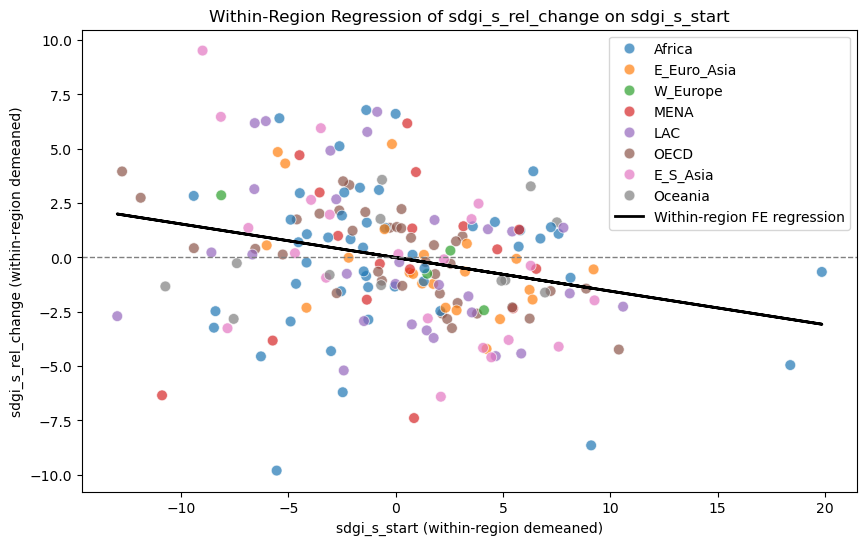

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# Prepare data
df = summary[['sdgi_s_start', 'sdgi_s_rel_change', 'region']].dropna()

# Ensure numeric
df['sdgi_s_start'] = pd.to_numeric(df['sdgi_s_start'], errors='coerce')
df['sdgi_s_rel_change'] = pd.to_numeric(df['sdgi_s_rel_change'], errors='coerce')
df = df.dropna(subset=['sdgi_s_start', 'sdgi_s_rel_change'])

# Within transformation (demean by region)
df['sdgi_s_start_within'] = df['sdgi_s_start'] - df.groupby('region')['sdgi_s_start'].transform('mean')
df['sdgi_s_rel_change_within'] = df['sdgi_s_rel_change'] - df.groupby('region')['sdgi_s_rel_change'].transform('mean')

df = df[df['sdgi_s_start_within'] > -25]

# Fit OLS on within-transformed data
X = sm.add_constant(df['sdgi_s_start_within'])
y = df['sdgi_s_rel_change_within']
model_within = sm.OLS(y, X).fit()
print(model_within.summary())

# Plot
plt.figure(figsize=(10,6))
sns.scatterplot(x='sdgi_s_start_within', y='sdgi_s_rel_change_within', hue='region', data=df, s=60, alpha=0.7)

# Plot regression line for overall within-effect
x_vals = pd.Series(df['sdgi_s_start_within'])
y_vals = model_within.params['const'] + model_within.params['sdgi_s_start_within'] * x_vals
plt.plot(x_vals, y_vals, color='black', linewidth=2, label='Within-region FE regression')

plt.axhline(0, color='grey', linestyle='--', linewidth=1)
plt.xlabel('sdgi_s_start (within-region demeaned)')
plt.ylabel('sdgi_s_rel_change (within-region demeaned)')
plt.title('Within-Region Regression of sdgi_s_rel_change on sdgi_s_start')
plt.legend()
plt.show()


In [23]:
df[df['sdgi_s_start_within'] < -25]

,sdgi_s_start,sdgi_s_rel_change,region,sdgi_s_start_within,sdgi_s_rel_change_within
id,,,,,
AFG,34.876604,14.225787,E_Euro_Asia,-30.293634,5.672309


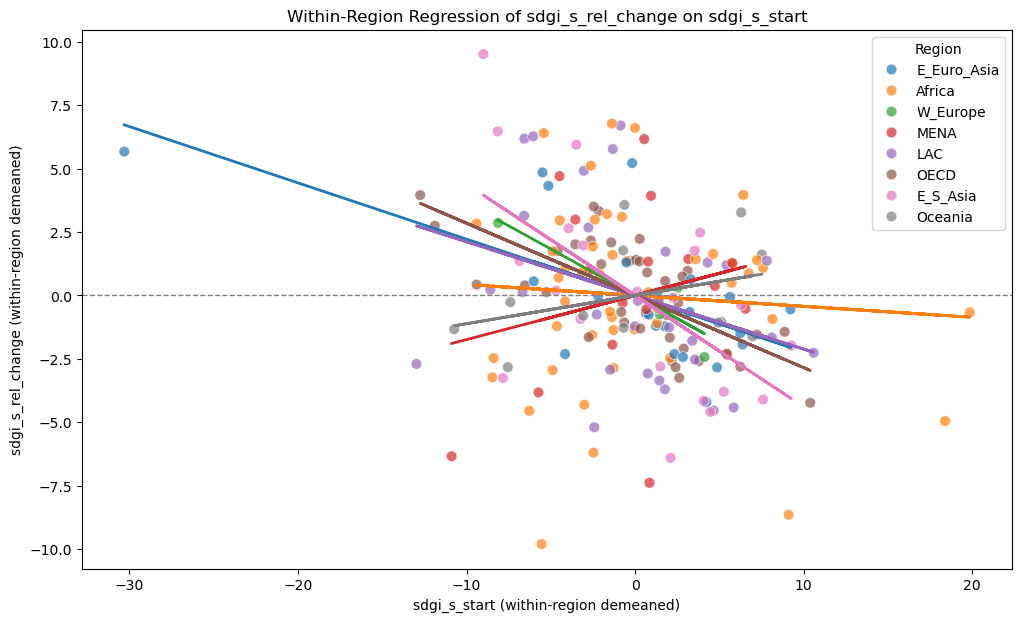

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# Prepare data
df = summary[['sdgi_s_start', 'sdgi_s_rel_change', 'region']].dropna()

# Ensure numeric
df['sdgi_s_start'] = pd.to_numeric(df['sdgi_s_start'], errors='coerce')
df['sdgi_s_rel_change'] = pd.to_numeric(df['sdgi_s_rel_change'], errors='coerce')
df = df.dropna(subset=['sdgi_s_start', 'sdgi_s_rel_change'])

# Within transformation (demean by region)
df['sdgi_s_start_within'] = df['sdgi_s_start'] - df.groupby('region')['sdgi_s_start'].transform('mean')
df['sdgi_s_rel_change_within'] = df['sdgi_s_rel_change'] - df.groupby('region')['sdgi_s_rel_change'].transform('mean')

# Plot setup
plt.figure(figsize=(12, 7))
sns.scatterplot(x='sdgi_s_start_within', y='sdgi_s_rel_change_within', hue='region', data=df, s=60, alpha=0.7)

# Fit and plot within-region regression lines
regions = df['region'].unique()
for r in regions:
    df_r = df[df['region'] == r]
    X_r = sm.add_constant(df_r['sdgi_s_start_within'])
    y_r = df_r['sdgi_s_rel_change_within']
    model_r = sm.OLS(y_r, X_r).fit()
    x_vals = pd.Series(df_r['sdgi_s_start_within'])
    y_vals = model_r.params['const'] + model_r.params['sdgi_s_start_within'] * x_vals
    plt.plot(x_vals, y_vals, linewidth=2)

plt.axhline(0, color='grey', linestyle='--', linewidth=1)
plt.xlabel('sdgi_s_start (within-region demeaned)')
plt.ylabel('sdgi_s_rel_change (within-region demeaned)')
plt.title('Within-Region Regression of sdgi_s_rel_change on sdgi_s_start')
plt.legend(title='Region')
plt.show()


                               WLS Regression Results                               
Dep. Variable:     sdgi_s_rel_change_within   R-squared:                       0.008
Model:                                  WLS   Adj. R-squared:                  0.003
Method:                       Least Squares   F-statistic:                     1.547
Date:                      Fri, 03 Oct 2025   Prob (F-statistic):              0.215
Time:                              14:46:48   Log-Likelihood:                -630.89
No. Observations:                       193   AIC:                             1266.
Df Residuals:                           191   BIC:                             1272.
Df Model:                                 1                                         
Covariance Type:                  nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------

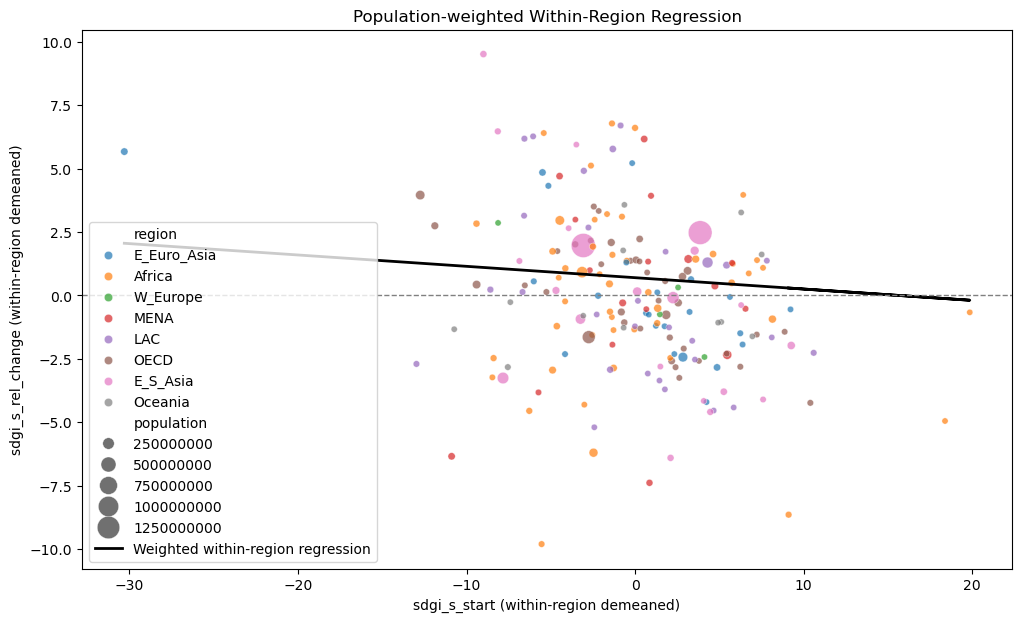

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# Prepare data
df = summary[['sdgi_s_start', 'sdgi_s_rel_change', 'region', 'population']].dropna()

# Ensure numeric
df['sdgi_s_start'] = pd.to_numeric(df['sdgi_s_start'], errors='coerce')
df['sdgi_s_rel_change'] = pd.to_numeric(df['sdgi_s_rel_change'], errors='coerce')
df['population'] = pd.to_numeric(df['population'], errors='coerce')
df = df.dropna(subset=['sdgi_s_start', 'sdgi_s_rel_change', 'population'])

# Within transformation (demean by region)
df['sdgi_s_start_within'] = df['sdgi_s_start'] - df.groupby('region')['sdgi_s_start'].transform('mean')
df['sdgi_s_rel_change_within'] = df['sdgi_s_rel_change'] - df.groupby('region')['sdgi_s_rel_change'].transform('mean')

# Fit weighted OLS (weights = population)
X = sm.add_constant(df['sdgi_s_start_within'])
y = df['sdgi_s_rel_change_within']
weights = df['population']
model_weighted = sm.WLS(y, X, weights=weights).fit()

print(model_weighted.summary())

# Plot scatter with population weighting (point size proportional to population)
plt.figure(figsize=(12,7))
sns.scatterplot(
    x='sdgi_s_start_within', 
    y='sdgi_s_rel_change_within', 
    hue='region', 
    size='population',
    sizes=(20, 300), 
    alpha=0.7,
    data=df
)

# Weighted regression line
x_vals = pd.Series(df['sdgi_s_start_within'])
y_vals = model_weighted.params['const'] + model_weighted.params['sdgi_s_start_within'] * x_vals
plt.plot(x_vals, y_vals, color='black', linewidth=2, label='Weighted within-region regression')

plt.axhline(0, color='grey', linestyle='--', linewidth=1)
plt.xlabel('sdgi_s_start (within-region demeaned)')
plt.ylabel('sdgi_s_rel_change (within-region demeaned)')
plt.title('Population-weighted Within-Region Regression')
plt.legend()
plt.show()
